In [1]:
#Generate plot 2 showing the efect of moments on the temp distribution.

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)

In [3]:
#Chicago
LAT        = 41.8781
LON        = 360-87.6298
# #Bengaluru:
# LAT        = 12.9716
# LON        = 77.5946
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc        = 'Chicago/'
locn       = 'Chicago'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(2)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35950 instead
  warnings.warn(


In [5]:
cluster

In [6]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
doy      = 211 # day_of_year
date     = 'Jul30'

In [7]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 746 ms, sys: 112 ms, total: 859 ms
Wall time: 1.39 s


In [8]:
%%time
#Close to (LAT, LON) ;t-temp, nw - no-warming, w-warming, hw = historical warming

tw    = ds_ssp.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy)
tnw   = ds_hist.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
thw   = ds_hist.TREFHTMX.sel(lat=LAT,lon=LON,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy)
tnw

CPU times: user 489 ms, sys: 5.9 ms, total: 495 ms
Wall time: 486 ms


<xarray.DataArray 'TREFHTMX' (time: 30, member: 100)>
dask.array<getitem, shape=(30, 100), dtype=float32, chunksize=(10, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 41.94
    lon      float64 272.5
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1850-07-30 00:00:00 ... 1879-07-30 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [9]:
%%time
#Get alll of the model warming data( historical and future) in one dataset.
modelw_path = cvals+loc+'tmw'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(modelw_path)
tmw         = xr.concat([thw,tw],dim='time')
tmw         =tmw.chunk({'time':10,'member':10})
tmw.to_dataset().to_zarr(modelw_path,mode='w')
#####
tmw         = xr.open_mfdataset(modelw_path,engine='zarr')
tmw         = tmw.TREFHTMX
#tmw.sel(time='18500730').values

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tmwJul30_1850_2100.zarr
CPU times: user 1min 9s, sys: 2.33 s, total: 1min 12s
Wall time: 5min 54s


In [10]:
#tmw.sel(time='18500730').values

In [11]:
tnw = tnw.rename({'time':'old_time'})
tnw = tnw.stack(mtime=('member','old_time'),create_index=False)
tnw = tnw.expand_dims(dim={'time':251}).assign_coords(time=('time',tmw.time.data))
tnw

<xarray.DataArray 'TREFHTMX' (time: 251, mtime: 3000)>
dask.array<broadcast_to, shape=(251, 3000), dtype=float32, chunksize=(251, 10), chunktype=numpy.ndarray>
Coordinates:
    lat       float64 41.94
    lon       float64 272.5
    member    (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99
    old_time  (mtime) object 1850-07-30 00:00:00 ... 1879-07-30 00:00:00
  * time      (time) object 1850-07-30 00:00:00 ... 2100-07-30 00:00:00
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [12]:
%%time
quants    = np.arange(0,1,0.001)
tmw_mroll = tmw.rolling({"time":30,"member":100}, center=True).mean()
tmw_sroll = tmw.rolling({"time":30,"member":100}, center=True).std()
qmw       = tmw.rolling({"time":30,"member":100}, center=True).construct(time='t1',member='t2')\
             .quantile(quants,dim={'t1','t2'},skipna=False)
qmw

CPU times: user 98.7 ms, sys: 11 ms, total: 110 ms
Wall time: 146 ms


<xarray.DataArray 'TREFHTMX' (quantile: 1000, time: 251, member: 100)>
dask.array<transpose, shape=(1000, 251, 100), dtype=float64, chunksize=(1000, 35, 100), chunktype=numpy.ndarray>
Coordinates:
  * member    (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time      (time) object 1850-07-30 00:00:00 ... 2100-07-30 00:00:00
  * quantile  (quantile) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

In [13]:
qmw.sel(time='20500730',quantile=0.25,member=50).values

array([304.93241119])

In [14]:
%%time
tmw_mroll = tmw_mroll.sel(member=50)
tmw_sroll = tmw_sroll.sel(member=50)
qmw       = qmw.sel(member=50)
tmw_mroll

CPU times: user 2.97 ms, sys: 0 ns, total: 2.97 ms
Wall time: 2.9 ms


<xarray.DataArray 'TREFHTMX' (time: 251)>
dask.array<getitem, shape=(251,), dtype=float32, chunksize=(35,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 41.94
    lon      float64 272.5
    member   int64 50
  * time     (time) object 1850-07-30 00:00:00 ... 2100-07-30 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

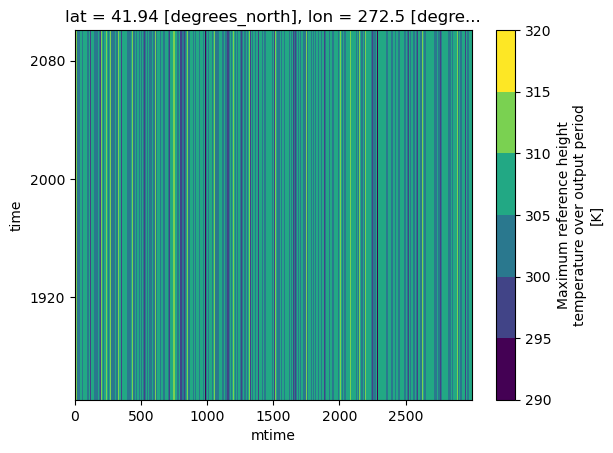

In [15]:
tnw.plot.contourf()

In [16]:
tmc     = (tnw - tnw.mean(dim='mtime'))+tmw_mroll
tmsc    = (tnw - tnw.mean())*(tmw_sroll/tnw.std('mtime')) + tmw_mroll
tmc     = tmc.chunk({'time':10,'mtime':3100})
tmsc    = tmsc.chunk({'time':10,'mtime':3100})
tmc

<xarray.DataArray 'TREFHTMX' (time: 251, mtime: 3000)>
dask.array<rechunk-merge, shape=(251, 3000), dtype=float32, chunksize=(10, 3000), chunktype=numpy.ndarray>
Coordinates:
    lat       float64 41.94
    lon       float64 272.5
    old_time  (mtime) object dask.array<chunksize=(3000,), meta=np.ndarray>
  * time      (time) object 1850-07-30 00:00:00 ... 2100-07-30 00:00:00
Dimensions without coordinates: mtime

In [18]:
%%time
# Set paths for local tmax - warming, no warming and corrected.
msc_path = cvals+loc+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
mc_path  = cvals+loc+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
print(msc_path)
print(mc_path)
# tmc.to_dataset().to_zarr(mc_path,mode='w')
# tmsc.to_dataset().to_zarr(msc_path,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tmscJul30_2071_2100.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tmcJul30_2071_2100.zarr
CPU times: user 39.6 s, sys: 1.22 s, total: 40.8 s
Wall time: 1min 58s


In [19]:
%%time
tmc      = xr.open_mfdataset(mc_path,engine='zarr')
tmsc     = xr.open_mfdataset(msc_path,engine='zarr')
tmc      = tmc.TREFHTMX
tmsc     = tmsc.TREFHTMX
#Compute quantiles
quants   = np.arange(0,1,0.001)
qmc      = tmc.quantile(quants,dim='mtime')
qmsc     = tmsc.quantile(quants,dim='mtime')
qmc

CPU times: user 409 ms, sys: 13.1 ms, total: 422 ms
Wall time: 412 ms


<xarray.DataArray 'TREFHTMX' (quantile: 1000, time: 251)>
dask.array<transpose, shape=(1000, 251), dtype=float64, chunksize=(1000, 10), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 1850-07-30 00:00:00 ... 2100-07-30 00:00:00
  * quantile  (quantile) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999

In [20]:
%%time
#Save all quantile functions
qmsc_path = cvals+loc+'qmsc'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qmc_path  = cvals+loc+'qmc'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qmw_path  = cvals+loc+'qmw'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
print(qmsc_path)
print(qmc_path)
print(qmw_path)
qmw       = qmw.chunk({'quantile':1000,'time':10})
qmc       = qmc.chunk({'quantile':1000,'time':10})
qmsc      = qmsc.chunk({'quantile':1000,'time':10})
# qmw.to_dataset().to_zarr(qmw_path,mode='w')
# qmc.to_dataset().to_zarr(qmc_path,mode='w')
# qmsc.to_dataset().to_zarr(qmsc_path,mode='w')

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/qmscJul30_1850_2100.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/qmcJul30_1850_2100.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/qmwJul30_1850_2100.zarr
CPU times: user 21.8 s, sys: 966 ms, total: 22.7 s
Wall time: 5min 14s


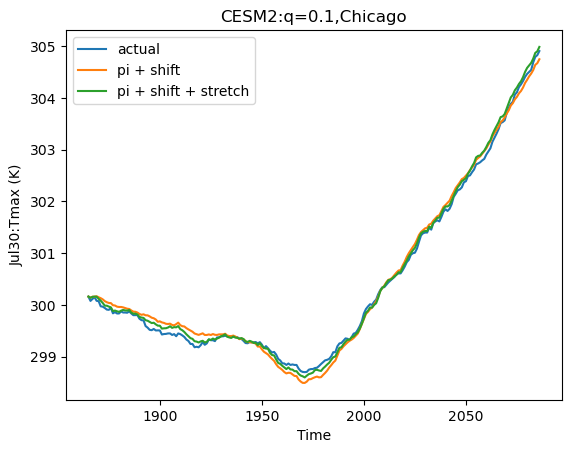

In [21]:
#Open quantiles and plot
year = np.arange(251)+1850 
qmw  = xr.open_mfdataset(qmw_path,engine='zarr')
qmw  = qmw.TREFHTMX
qmc  = xr.open_mfdataset(qmc_path,engine='zarr')
qmc  = qmc.TREFHTMX
qmsc = xr.open_mfdataset(qmsc_path,engine='zarr')
qmsc = qmsc.TREFHTMX
#qmw.sel(time='18500730').values
#############################
plt.plot(year,qmw.sel(quantile=0.1),label='actual')
plt.plot(year,qmc.sel(quantile=0.1),label='pi + shift')
plt.plot(year,qmsc.sel(quantile=0.1),label='pi + shift + stretch')
plt.legend(loc='upper left')
plt.title('CESM2:q=0.1,'+locn)
plt.ylabel(date+ ':Tmax (K)')
plt.xlabel('Time')
plt.show()

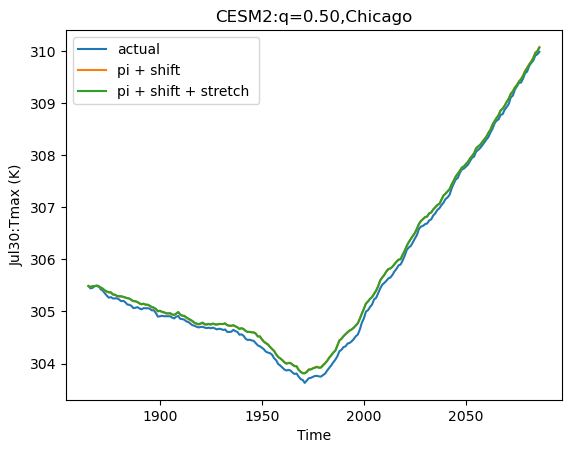

In [22]:
#Open quantiles and plot
year = np.arange(251)+1850 
qmw  = xr.open_mfdataset(qmw_path,engine='zarr')
qmw  = qmw.TREFHTMX
qmc  = xr.open_mfdataset(qmc_path,engine='zarr')
qmc  = qmc.TREFHTMX
qmsc = xr.open_mfdataset(qmsc_path,engine='zarr')
qmsc = qmsc.TREFHTMX
#qmw.sel(time='18500730').values
#############################
plt.plot(year,qmw.sel(quantile=0.50),label='actual')
plt.plot(year,qmc.sel(quantile=0.50),label='pi + shift')
plt.plot(year,qmsc.sel(quantile=0.50),label='pi + shift + stretch ')
plt.legend(loc='upper left')
plt.title('CESM2:q=0.50,'+locn)
plt.ylabel(date+ ':Tmax (K)')
plt.xlabel('Time')
plt.show()

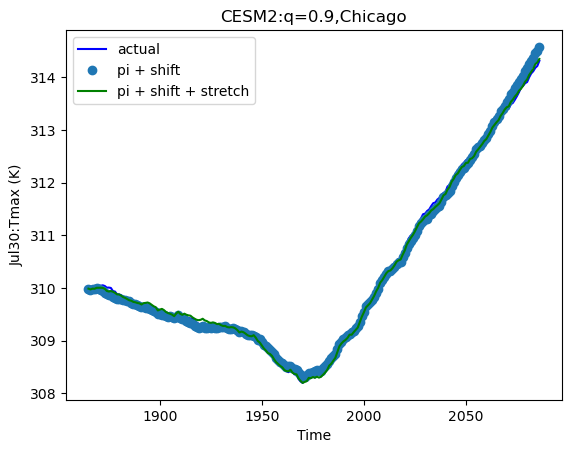

In [23]:
#Open quantiles and plot
year = np.arange(251)+1850 
qmw  = xr.open_mfdataset(qmw_path,engine='zarr')
qmw  = qmw.TREFHTMX
qmc  = xr.open_mfdataset(qmc_path,engine='zarr')
qmc  = qmc.TREFHTMX
qmsc = xr.open_mfdataset(qmsc_path,engine='zarr')
qmsc = qmsc.TREFHTMX
#qmw.sel(time='18500730').values
#############################
plt.plot(year,qmw.sel(quantile=0.9),'b',label='actual')
plt.plot(year,qmc.sel(quantile=0.9),'o',label='pi + shift')
plt.plot(year,qmsc.sel(quantile=0.9),'g',label='pi + shift + stretch')
plt.legend(loc='upper left')
plt.title('CESM2:q=0.9,'+locn)
plt.ylabel(date+ ':Tmax (K)')
plt.xlabel('Time')
plt.show()

CPU times: user 149 ms, sys: 11.4 ms, total: 160 ms
Wall time: 436 ms


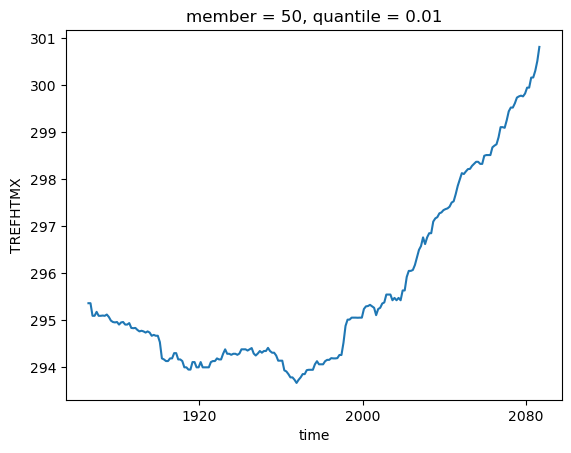

In [49]:
%%time
qmw.sel(quantile=0.01).plot()

In [50]:
#################### Junk and Tests #####################

In [51]:
%%time
#d = day/daily
tdnw = tnw.stack(mtime=('member','time'),create_index=False)
tdw  = tw.stack(mtime=('member','time'),create_index=True)
#twj30.mean().values - tnwj30.mean().values 
#tdw.std().values 

KeyError: 'member'

In [52]:
# Set paths for local tmax - warming, no warming and corrected.
nw_path  = cvals+loc+'tnw'+date+'_'+ic_year0+'_'+ic_year1+'_zarr'
w_path   = cvals+loc+'tw'+date+'_'+ic_year0+'_'+ic_year1+'_zarr'
msc_path = cvals+loc+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'_zarr'
mc_path  = cvals+loc+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_zarr'
print(nw_path) 
print(w_path)
print(mc_path)

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tnwJul30_2071_2100_zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/twJul30_2071_2100_zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tmcJul30_2071_2100_zarr


In [53]:
%%time
# # Save daily,local tmax, mc = mean corrected, ms = mean and std-corrected
# tdmc   = (tdnw - tdnw.mean())+tdw.mean()
# tdmsc  = (tdnw - tdnw.mean())*(tdw.std()/tdnw.std()) + tdw.mean()
# #Check if the transformation is correct
#tdmc.mean().values - tdw.mean().values
tnw.to_dataset().to_zarr(nw_path,mode='w')
tw.to_dataset().to_zarr(w_path,mode='w')
tmc.to_dataset().to_zarr(mc_path,mode='w')
tmsc.to_dataset().to_zarr(msc_path,mode='w')

CPU times: user 22.1 s, sys: 3.29 s, total: 25.4 s
Wall time: 2min 31s


In [54]:
#Test if the rolling construct and quantiles are working properly on arr
arr = xr.DataArray(np.arange(0, 7.5, 0.5).reshape(3, 5), dims=("x", "y"))
arr

<xarray.DataArray (x: 3, y: 5)>
array([[0. , 0.5, 1. , 1.5, 2. ],
       [2.5, 3. , 3.5, 4. , 4.5],
       [5. , 5.5, 6. , 6.5, 7. ]])
Dimensions without coordinates: x, y

In [55]:
tarr    = arr.rolling({'x':2,'y':3},center=True,min_periods=2).construct(x='t1',y='t2')
arr_q50 = tarr.reduce(np.quantile,dim=['t1','t2'],q=0.5)
q50arr  = tarr.quantile(0.50,dim={'t1','t2'})
q50arr

<xarray.DataArray (x: 3, y: 5)>
array([[0.25, 0.5 , 1.  , 1.5 , 1.75],
       [1.5 , 1.75, 2.25, 2.75, 3.  ],
       [4.  , 4.25, 4.75, 5.25, 5.5 ]])
Coordinates:
    quantile  float64 0.5
Dimensions without coordinates: x, y

In [56]:
arr_q50
#This clearly gives nan for undesirable entries. For example, second row, first column. 
#So, it is better to use the former method of using quantile on a data array instead of 
#using reduce. Just remember to manually, exclude entries that don't make sense for  a centred
#window.

<xarray.DataArray (x: 3, y: 5)>
array([[ nan,  nan,  nan,  nan,  nan],
       [ nan, 1.75, 2.25, 2.75,  nan],
       [ nan, 4.25, 4.75, 5.25,  nan]])
Dimensions without coordinates: x, y

In [57]:
a = [0,0.5,2.5,3]
np.quantile(a,0.5)

1.5

In [58]:
%%time
quants = np.arange(0,1,0.001)
test_w = tw.rolling({"time":30,"member":100}, center=True).\
construct(time='tmp1',member='tmp2')
#test_w2 = tw.groupby('time.year').rolling({'year':30,'member':100})
qw     = tw.rolling({"time":30,"member":100}, center=True).\
construct(time='tmp1',member='tmp2').quantile(quants, dim={'tmp1','tmp2'})
# qnw    = tnw.rolling({"time":30,"member":100}, center=True).\
# construct(time='tmp1',member='tmp2').quantile(.25, dim={'tmp1','tmp2'})
# qmc     = tmc.rolling({"time":30,"member":100}, center=True).\
# construct(time='tmp1',member='tmp2').quantile(.25, dim={'tmp1','tmp2'})
# qmsc    = tmsc.rolling({"time":30,"member":100}, center=True).\
# construct(time='tmp1',member='tmp2').quantile(.25, dim={'tmp1','tmp2'})

CPU times: user 40.7 ms, sys: 4.93 ms, total: 45.7 ms
Wall time: 43.4 ms


In [59]:
#Plot quantiles 
years     = qw.time[15:71]
#years

In [60]:
qw.plot.contourf()

ValueError: DataArray must be 2d

In [ ]:
qw.sel(quantile=0.25).plot.contourf()

In [ ]:
qw.sel(quantile=0.25,time='20250730').values

In [ ]:
%%time
#Compute quantile function - Jan 1 tmax
quants = np.arange(0,1,0.001)
qdnw   = tdnw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdw    = tdw.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc   = tdmc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmsc  = tdmsc.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

In [ ]:
%%time
q50w     = tw.rolling({"time":30,"member":100}, center=True).\
construct(time='tmp1',member='tmp2').quantile(.50, dim={'tmp1','tmp2'})
q50mc    = tmc.rolling({"time":30,"member":100}, center=True).\
construct(time='tmp1',member='tmp2').quantile(.50, dim={'tmp1','tmp2'})
q50msc   = tmsc.rolling({"time":30,"member":100}, center=True).\
construct(time='tmp1',member='tmp2').quantile(.50, dim={'tmp1','tmp2'})
#q50w.isel(member=0).plot()
q50mc.isel(member=0)

In [ ]:
plt.plot(years,q50w.isel(member=0).sel(time=slice('20300730','20850730')),label='warm')
plt.plot(years,q50mc.isel(member=0).sel(time=slice('20300730','20850730')),label='mean-only')
plt.plot()

In [ ]:
%%time
q99w     = tw.rolling({"time":30,"member":100}, center=True).\
construct(time='tmp1',member='tmp2').quantile(.99, dim={'tmp1','tmp2'})
q99w.isel(member=0).plot()

In [ ]:
qdw_path    = cvals+'qw'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdnw_path   = cvals+'qnw'+date+'_'+pi_year0+'_'+pi_year1+'.zarr'
qdmc_path   = cvals+'qmc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdmsc_path  = cvals+'qmsc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [ ]:
%%time
plt.plot(quants,qdnw,label='pre-ind:'+pi_year0+'-'+pi_year1)
plt.plot(quants,qdmc,label='pre-ind+ mean of '+ic_year0+'-'+ic_year1)
plt.plot(quants,qdmsc,label='pre-ind + mean and std-adj '+ic_year0+'-'+ic_year1)
plt.plot(quants,qdw,label= ic_year0+'-'+ic_year1)
plt.legend(loc='upper left')
plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON)+locn)
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
tdw

In [ ]:
%%time
######## Boostrap Confidence Intervals for the quantiles #####
#a = anopmaly, b=bootstrap samples
nboot   = 1000
# tdnwb   = xs.resample_iterations(tdnw,nboot,'mtime')
# tdcb    = xs.resample_iterations(tdc,nboot,'mtime')
# tdmcb   = xs.resample_iterations(tdmc,nboot,'mtime')
# qdnwb   = tdnwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdcb    = tdcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdmcb   = tdmcb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdwab   = qdwb - qdnwb
# qdcab   = qdcb - qdnwb
# qdmcab  = qdmcb - qdnwb
tdwb    = xs.resample_iterations(tdw,nboot,'mtime')
qdwb    = tdwb.chunk(dict(mtime=-1,iteration=-1)).quantile(quants,dim='mtime')
qdwb

In [ ]:
%%time
qdwb     = qdwb.rename({'quantile':'permilles'})
CIs      = [0.025,0.975]
qdw_ci   = qdwb.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')

In [ ]:
qdw_ci

In [ ]:
%%time
## Save CIs
qdw_cipath  = cvals+'qdw_ci' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qdw_ci.to_dataset().to_zarr(qdw_cipath,mode='w')

In [ ]:
%%time
qdw_ci   = xr.open_mfdataset(qdw_cipath,engine='zarr')
qdw_ci   = qdw_ci.TREFHTMX

In [ ]:
qdmc

In [ ]:
%%time
plt.plot(quants,qdnw,label=pi_year0+'_'+pi_year1)
plt.plot(quants,qdw,label=ic_year0+'_'+ic_year1)
plt.plot(quants,qdmc,label= 'mean-adj')
plt.plot(quants,qdmsc,label='mean and std-adj')
plt.fill_between(quants,qdw_ci.sel(quantile=0.025),qdw_ci.sel(quantile=0.975),color='r',alpha=0.1)
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn)
plt.ylabel(date+'Tmax (K)')
plt.xlabel('Quantiles')
plt.show()